# Fine-tune RuBert
Скачаем и используем ruBert-base https://huggingface.co/ai-forever/ruBert-base/tree/main

In [1]:
import time
import datetime
import random
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import matthews_corrcoef
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Зададим локальный путь к скачанной модели ruBert и размер batch.

In [2]:
PATH = r'H:\Инструменты\Windows\GPT or another LLM\ruBert-base 2021'
BATCH_SIZE = 16

# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

Необходимые определения:

In [3]:
def get_max_len_in_tokens(sentences, tokenizer):
    max_len = 0

    # For every sentence...
    for sent in sentences:

        # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
        input_ids = tokenizer.encode(sent, add_special_tokens=True)

        # Update the maximum sentence length.
        max_len = max(max_len, len(input_ids))

    return max_len


def tokenize_sentences(sentences, tokenizer, max_len, labels):
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_len,           # Pad & truncate all sentences.
                            padding='max_length',
                            truncation=True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                    )

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels


def create_tensor_dataset(sentences, tokenizer, max_len, labels_values):
    input_ids, attention_masks, labels = tokenize_sentences(sentences, tokenizer, max_len, labels_values)

    # Print sentence 0, now as a list of IDs.
    print('Original: ', sentences[0])
    print('Token IDs:', input_ids[0])

    return TensorDataset(input_ids, attention_masks, labels)


# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


def train(epochs, model, train_dataloader, validation_dataloader, optimizer, scheduler):
    # We'll store a number of quantities such as training and validation loss,
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()

    # For each epoch...
    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode. Don't be mislead--the call to
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader.
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids
            #   [1]: attention masks
            #   [2]: labels
            b_input_ids = batch[0].to(DEVICE)
            b_input_mask = batch[1].to(DEVICE)
            b_labels = batch[2].to(DEVICE)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because
            # accumulating the gradients is "convenient while training RNNs".
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()

            # Perform a forward pass (evaluate the model on this training batch).
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # It returns different numbers of parameters depending on what arguments
            # arge given and what flags are set. For our useage here, it returns
            # the loss (because we provided labels) and the "logits"--the model
            # outputs prior to activation.
            res = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask,
                                labels=b_labels)
            loss = res['loss']
            logits = res['logits']

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value
            # from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:

            # Unpack this training batch from our dataloader.
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids
            #   [1]: attention masks
            #   [2]: labels
            b_input_ids = batch[0].to(DEVICE)
            b_input_mask = batch[1].to(DEVICE)
            b_labels = batch[2].to(DEVICE)

            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here:
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                res = model(b_input_ids,
                                    token_type_ids=None,
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
            loss = res['loss']
            logits = res['logits']

            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)


        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    return training_stats


def display_train_stats(training_stats, epochs):
    # Create a DataFrame from our training statistics.
    df_stats = pd.DataFrame(data=training_stats)

    # Use the 'epoch' as the row index.
    df_stats = df_stats.set_index('epoch')

    # A hack to force the column headers to wrap.
    #df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

    # Display the table.
    print(df_stats)

    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # Plot the learning curve.
    plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
    plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks(list(range(1, epochs + 1)))

    plt.show()


def get_predictions(model, dataloader):
    print('Predicting labels for {:,} sentences...'.format(len(dataloader)))

    # Put model in evaluation mode
    model.eval()

    # Tracking variables
    predictions , true_labels = [], []

    # Predict
    for batch in dataloader:
        # Add batch to GPU
        batch = tuple(t.to(DEVICE) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

    print('    DONE.')
    return predictions, true_labels


def get_matthews_corrcoef_score(predictions, true_labels):
    # Combine the results across all batches.
    flat_predictions = np.concatenate(predictions, axis=0)

    # For each sample, pick the label (0 or 1) with the higher score.
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

    # Combine the correct labels for each batch into a single list.
    flat_true_labels = np.concatenate(true_labels, axis=0)

    # Calculate the MCC
    mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
    return mcc

## Загрузим наборы данных
(Тренировочный, валидационный и тестовый.)

In [4]:
df_train = pd.read_csv('in_domain_train_subset.csv')
df_val = pd.read_csv('in_domain_validation_subset.csv')
df_test = pd.read_csv('in_domain_test.csv')
print('Train dataset:\n', df_train.head())
print('Validation dataset:\n', df_val.head())
print('Test dataset:\n', df_test.head())

Train dataset:
                                             sentence  acceptable
0                          О староверах я уже писал.           1
1  Христофоров, явившийся в ложу первым и одиноко...           0
2  Она так и сидела в гостинной, окруженная полто...           0
3  Он купит машину, если только не пропьет все де...           1
4                           Детям не было где спать.           1
Validation dataset:
                                             sentence  acceptable
0  Для проведения этой операции ему дали целую ар...           1
1                 Рядом с местом стула лежал коврик.           0
2                       Ашот лежал около меня, спал.           1
3  Так вот, в те страны, где они, по всяким причи...           0
4  Иван не жалеет, что поехал на конференцию в Ма...           1
Test dataset:
                                             sentence  acceptable
0                            Иван вчера не позвонил.           1
1  У многих туристов, кто посещают Кем

## Загрузим tokenizer

In [5]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(PATH)
#pipe.save_pretrained(r'V:\checkpoint')

Loading BERT tokenizer...


## Определим максимальную длину последовательности 
(в токенах)

In [6]:
sentences = df_train.sentence.values
labels_values = df_train.acceptable.values

#sentence0 = df_train.at[0, 'sentence']
print(sentences[0])
print('Original: ', sentences[0])
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
print('Token ids:', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))
max_len = get_max_len_in_tokens(sentences, tokenizer)
max_len = max(max_len, get_max_len_in_tokens(df_val.sentence, tokenizer))
max_len = max(max_len, get_max_len_in_tokens(df_test.sentence, tokenizer))
print(max_len)

О староверах я уже писал.
Original:  О староверах я уже писал.
Tokenized:  ['о', 'старо', '##верах', 'я', 'уже', 'писал', '.']
Token ids: [104, 7697, 69677, 119, 965, 6378, 126]
45


## Подготовим datasets для тренировки модели

In [7]:
train_dataset = create_tensor_dataset(sentences, tokenizer, max_len, labels_values)
val_dataset = create_tensor_dataset(df_val.sentence.values, tokenizer, max_len, df_val.acceptable.values)

Original:  О староверах я уже писал.
Token IDs: tensor([  101,   104,  7697, 69677,   119,   965,  6378,   126,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])
Original:  Для проведения этой операции ему дали целую армию.
Token IDs: tensor([  101,   849,  5303,   736,   378,  4620,  1211,  7240, 16344,  9395,
          126,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])


In [8]:
# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = BATCH_SIZE # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE # Evaluate with this batch size.
        )

## Загрузим модель

In [9]:
# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    PATH, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at H:\Инструменты\Windows\GPT or another LLM\ruBert-base 2021 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

## Подготовимся к fine-tune модели

In [10]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 3e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [11]:
# Number of training epochs. The BERT authors recommend between 2 and 4.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

### Выполним доучивание модели (fine-tune)

In [12]:
training_stats = train(epochs, model, train_dataloader, validation_dataloader, optimizer, scheduler)


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    433.    Elapsed: 0:00:05.
  Batch    80  of    433.    Elapsed: 0:00:10.
  Batch   120  of    433.    Elapsed: 0:00:14.
  Batch   160  of    433.    Elapsed: 0:00:19.
  Batch   200  of    433.    Elapsed: 0:00:23.
  Batch   240  of    433.    Elapsed: 0:00:27.
  Batch   280  of    433.    Elapsed: 0:00:32.
  Batch   320  of    433.    Elapsed: 0:00:36.
  Batch   360  of    433.    Elapsed: 0:00:41.
  Batch   400  of    433.    Elapsed: 0:00:45.

  Average training loss: 0.52
  Training epcoh took: 0:00:49

Running Validation...
  Accuracy: 0.79
  Validation Loss: 0.46
  Validation took: 0:00:01

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    433.    Elapsed: 0:00:04.
  Batch    80  of    433.    Elapsed: 0:00:09.
  Batch   120  of    433.    Elapsed: 0:00:13.
  Batch   160  of    433.    Elapsed: 0:00:18.
  Batch   200  of    433.    Elapsed: 0:00:22.
  Batch   240  of    433.    Elapsed: 0:00:26.
  Batch  

       Training Loss  Valid. Loss  Valid. Accur. Training Time Validation Time
epoch                                                                         
1           0.521295     0.462300       0.785417       0:00:49         0:00:01
2           0.295639     0.553638       0.795833       0:00:48         0:00:01


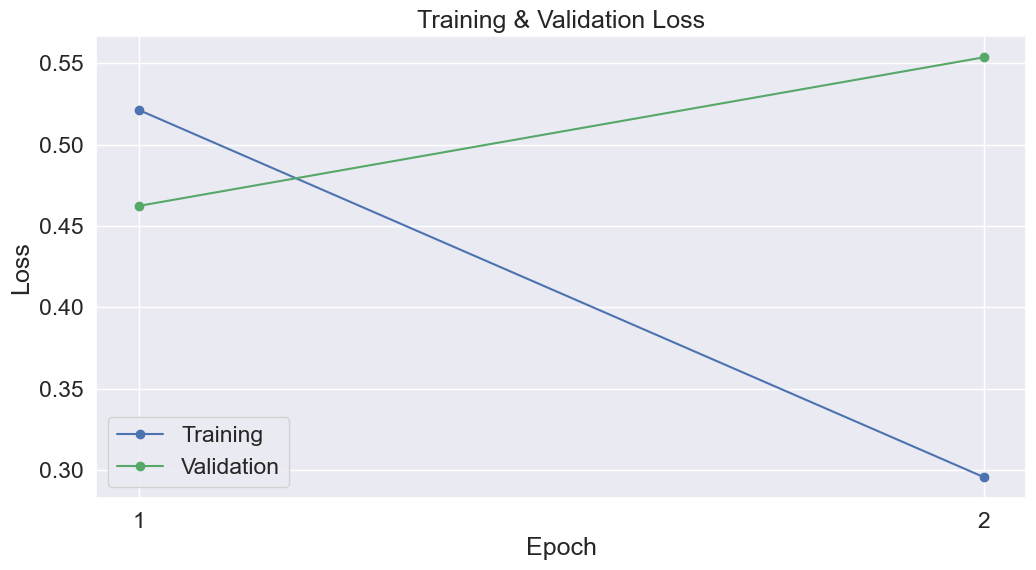

In [13]:
display_train_stats(training_stats, epochs)

In [14]:
test_dataset = create_tensor_dataset(df_test.sentence.values, tokenizer, max_len, df_test.acceptable.values)

test_dataloader = DataLoader(
            test_dataset, # The test samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE # Evaluate with this batch size.
        )

Original:  Иван вчера не позвонил.
Token IDs: tensor([   101, 104691,    379,   5171,    672,  14207,    126,    102,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0])


## Качество на отложенной выборке

In [15]:
   
predictions, true_labels = get_predictions(model, test_dataloader)
mcc = get_matthews_corrcoef_score(predictions, true_labels)
print('Total MCC: %.3f' % mcc)


Predicting labels for 62 sentences...
    DONE.
Total MCC: 0.390
